In [ ]:
from datetime import date, datetime as dt, timedelta as td
import pytz
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, SimpleRNN, Flatten, TimeDistributed, ConvLSTM2D, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing functions

In [ ]:
PATH = 'drive/MyDrive/Colab Notebooks/StepCount.csv'
data = pd.read_csv(PATH)

In [ ]:
def convert_steps(steps, grouping=['date']):
  convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('Europe/Vilnius'))
  get_year = lambda x: convert_tz(x).year
  get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month)
  get_date = lambda x: '{}-{:02}-{:02}'.format(convert_tz(x).year, convert_tz(x).month, convert_tz(x).day)
  get_day = lambda x: convert_tz(x).day
  get_hour = lambda x: convert_tz(x).hour
  get_minute = lambda x: convert_tz(x).minute
  get_day_of_week = lambda x: convert_tz(x).weekday()


  steps['startDate'] = pd.to_datetime(steps['startDate'])
  steps['year'] = steps['startDate'].map(get_year)
  steps['month'] = steps['startDate'].map(get_month)
  steps['date'] = steps['startDate'].map(get_date)
  steps['day'] = steps['startDate'].map(get_day)
  steps['hour'] = steps['startDate'].map(get_hour)
  steps['dow'] = steps['startDate'].map(get_day_of_week)

  corona_start = steps[steps.date == "2020-03-10"].index[0]
  steps = steps.iloc[:corona_start, :]

  return steps.groupby(grouping)['value'].sum().reset_index(name='Steps')


def prepare_sequence(sequence, n_previous, n_future):
    """
    Input: 
        - sequence: numpy array, pandas DataFrame or list; input sequence
        - n_previous: int; number of past data points (N)
        - n_future: int; number of data points to be predicted (K)
    Returns:
        - X: (seq. length x n_previous) numpy array with the previous observations
        - y: (seq. length x n_fututre) numpy array with the target observations
    """
    
    X, y = [], []
    idx, i = 0, 0
    while idx+n_future <= len(sequence)-1:
        idx = i + n_previous
        X.append(sequence[i:idx])
        y.append(sequence[idx:idx+n_future])
        i += 1
        
    return np.array(X), np.array(y)


def season(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3


def augment(steps):
    augmented = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')
    dow = steps.groupby(['date']).mean()['dow']
    augmented['dow'] = (dow.apply(int)).to_list()
    month = augmented.date.apply(lambda a: int(a.split('-')[1]))
    augmented['season'] = month.apply(season)
    
    return augmented

# Load and prepare the data

In [ ]:
steps_by_date = convert_steps(data)
steps_by_date_hour = convert_steps(data, ['date', 'hour'])

# Remove an invalid day
#steps_by_date = steps_by_date.iloc#[:-1]

# Replace the unrealistic values with the median
steps_by_date.Steps[steps_by_date.Steps < 300] = steps_by_date.Steps.median()

# Augent the data
augmented_steps_by_date = augment(data)
#augmented_steps_by_date = augmented_steps_by_date.iloc[:-1]
augmented_steps_by_date.Steps[augmented_steps_by_date.Steps < 300] = augmented_steps_by_date.Steps.median()
augmented_steps_by_date = pd.concat([augmented_steps_by_date.Steps, pd.DataFrame(to_categorical(augmented_steps_by_date.dow))], axis=1)

## Prepare the data for different models

In [ ]:
class Configuration:
  def __init__(self, name, model, n, k, X_train, y_train, X_val, y_val, X_test,
               y_test, predictions, scaler, m_batch_size=8, history=None):
    self.name = name
    self.model = model
    self.n = n
    self.k = k
    self.X_train = X_train
    self.y_train = y_train
    self.X_val = X_val
    self.y_val = y_val
    self.X_test = X_test
    self.y_test = y_test
    self.predictions = predictions
    self.scaler = scaler
    self.m_batch_size = m_batch_size

  def __repr__(self):
    return "{}, {}, {}, {}, {}, {}, {}".format(
        self.name, self.n, self.k, self.X_train.shape,
        self.y_train.shape, self.X_test.shape, self.y_test.shape)
    
  def plot_predictions(self):
    if self.k == 1 and self.predictions is not None:
      plt.figure(figsize=(20, 5))
      plt.plot(self.y_test.squeeze())
      plt.plot(self.predictions)
    else:
      print("k > 1")

  def plot_history(self):
    if history is not None:
      plt.figure(figsize=(20, 5))
      plt.plot(self.history.history['loss'])
      plt.plot(self.history.history['val_loss'])
      plt.plot(self.history.history['mean_absolute_error'])
      plt.plot(self.history.history['val_mean_absolute_error'])
      plt.legend()

In [ ]:
def prepare_data(data, n_k, models):
    # Split to training, validation and test sets
    n = len(data)
    train_data = data[0:int(n*0.8)]
    val_data = data[int(n*0.8):int(n*0.9)]
    test_data = data[int(n*0.9):]

    # Normalize the data with MinMax normalization
    scaler = MinMaxScaler() 
    train_data = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))
    val_data = scaler.transform(val_data.to_numpy().reshape(-1, 1))
    test_data = scaler.transform(test_data.to_numpy().reshape(-1, 1))

    for n, k in n_k:
        # Split data into windows
        X_train, y_train = prepare_sequence(
            np.concatenate((train_data, val_data[:k])), n, k)
        X_val, y_val = prepare_sequence(
            np.concatenate((val_data, test_data[:k])), n, k)
        X_test, y_test = prepare_sequence(test_data, n, k)

        # Add baseline
        models[f"Baseline_{n}_{k}"] = Configuration(
            name="Baseline",
            model=None,
            n=n, k=k,
            X_train=X_train, y_train=y_train,
            X_val=X_val, y_val=y_val,
            X_test=X_test, y_test=y_test, 
            predictions=None,
            scaler=scaler
            )
        
        # Add RNNs
        for name in ["LSTM", "BLSTM", "SimpleRNN", "GRU"]:
            # Reshape to (samples, timesteps, features)
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
            X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
            # Add to models
            models[name+f"_{n}_{k}"] = Configuration(
                name=name,
                model=None,
                n=n, k=k,
                X_train=X_train, y_train=y_train,
                X_val=X_val, y_val=y_val,
                X_test=X_test, y_test=y_test, 
                predictions=None,
                scaler=scaler,
                m_batch_size=6
                )

        # Add ConvLSTM
        if n%2 != 0:
            X_train, y_train = prepare_sequence(train_data.tolist()+val_data.tolist()[:k], n+1, k)
            X_val, y_val = prepare_sequence(val_data.tolist()+test_data.tolist()[:k], n+1, k)
            X_test, y_test = prepare_sequence(test_data, n+1, k)
        else:
            X_train, y_train = prepare_sequence(train_data.tolist()+val_data.tolist()[:k], n, k)
            X_val, y_val = prepare_sequence(val_data.tolist()+test_data.tolist()[:k], n, k)
            X_test, y_test = prepare_sequence(test_data, n, k)

        X_train = X_train.reshape(X_train.shape[0], 2, 1, X_train.shape[1]//2, 1)
        X_val = X_val.reshape(X_val.shape[0], 2, 1, X_val.shape[1]//2, 1)
        X_test = X_test.reshape(X_test.shape[0], 2, 1, X_test.shape[1]//2, 1)

        models[f"ConvLSTM_{n}_{k}"] = Configuration(
            name="ConvLSTM",
            model=None, 
            n=n, k=k,
            X_train=X_train, y_train=y_train,
            X_val=X_val, y_val=y_val,
            X_test=X_test, y_test=y_test, 
            predictions=None,
            scaler=scaler,
            m_batch_size=8)


In [ ]:
n_k_date = [(7, 1), (14, 1)]
n_k_hour = [(24, 24), (48, 24), (72, 24)]
models = dict()

prepare_data(steps_by_date.Steps, n_k_date, models)
prepare_data(steps_by_date_hour.Steps, n_k_hour, models)

# Pipeline

In [ ]:
results = pd.DataFrame(columns=["Model", "N_K", "MAE", "RMSE", "Error_Steps"])

## Baseline

In [ ]:
"""def average(history, n, k):
  if k == 1:
    return np.mean(history[-n:])
  else:
    predictions = []
    while k != 0:
      prediction = np.mean(history[-n:])
      predictions.append(prediction)
      history = np.append(history, prediction)
      k -= 1
    return predictions"""

def naive(X_test, n, k):
    if k == 1:
        return X_test[:, -1].flatten()
    
    predictions = []
    for i in range(len(X_test)):
        t = k
        curr_window = X_test[i, :]
        curr_predictions = []
        while t != 0:
            prediction = curr_window[-1]
            curr_predictions.append(prediction)
            curr_window = np.append(curr_predictions, prediction)
            t -= 1
        predictions.append(curr_predictions)
    return predictions

In [ ]:
row = 0


for key in models.keys():
  if key.startswith("Baseline"):
    print(f"{key}")
    current = models[key]

    """history = models[key].X_train.flatten()

    # Predict
    baseline_predictions = list()
    for t in range(len(models[key].y_test)):
        baseline_predictions.append(average(history, models[key].n, models[key].k))
        history = np.append(history, models[key].y_test.squeeze()[t])"""

    # Predict
    baseline_predictions = naive(current.X_test, current.n, current.k)
    models[key].predictions = baseline_predictions

    # Evaluate
    rmse = sqrt(mean_squared_error(current.y_test.squeeze(), baseline_predictions))
    mae = mean_absolute_error(current.y_test.squeeze(), baseline_predictions)
    error_steps = int(
        current.scaler.inverse_transform(np.array(mae).reshape(1, -1))[0][0])
    print(f"MAE: {mae}\nRMSE: {rmse}\nMAE in steps: {error_steps}\n")

    results.loc[row] = [
                        "Baseline", "{}_{}".format(current.n, current.k),
                        round(mae, 4),
                        round(rmse, 4),
                        error_steps]

    row += 1

Baseline_7_1
MAE: 0.11301282082283469
RMSE: 0.15260223140764395
MAE in steps: 3638

Baseline_14_1
MAE: 0.11262416448780238
RMSE: 0.1536436458787797
MAE in steps: 3626

Baseline_24_24
MAE: 0.09439987310452636
RMSE: 0.1312598478102069
MAE in steps: 798

Baseline_48_24
MAE: 0.09430587338025039
RMSE: 0.13126687196260914
MAE in steps: 797

Baseline_72_24
MAE: 0.0941613503346036
RMSE: 0.13124635608724658
MAE in steps: 796



## LSTM

In [ ]:
def vanilla_LSTM(n_units, n_timesteps, n_features, next_predicted=1):
  model = Sequential()
  model.add(
      LSTM(n_units, input_shape=(n_timesteps, n_features), activation='tanh'))
  model.add(Dense(next_predicted))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
  return model

In [ ]:
for key in models.keys():
  if key.startswith("LSTM"):
    print(f"{key} model is training")
    current = models[key]

    # Input shape
    _, n_timestamps, n_features = current.X_train.shape

    # Build model
    model = vanilla_LSTM(1, n_timestamps, n_features, current.k)

    # Fit the model
    history = model.fit(
        current.X_train,
        current.y_train,
        epochs=300,
        validation_data=(current.X_val, current.y_val),
        verbose=0,
        shuffle=False,
        batch_size=current.m_batch_size,
        callbacks=[EarlyStopping(
            monitor='val_mean_absolute_error',
            min_delta=0.0000001,
            patience=20,
            restore_best_weights=True)])

    # Predict
    predictions = model.predict(current.X_test)
    models[key].predictions = predictions
    models[key].history = history

    # Evaluate
    rmse = sqrt(mean_squared_error(current.y_test.squeeze(), predictions))
    mae = mean_absolute_error(current.y_test.squeeze(), predictions)
    error_steps = int(
        current.scaler.inverse_transform(np.array(mae).reshape(1, -1))[0][0])
    print(f"MAE: {mae}\nRMSE: {rmse}\nMAE in steps: {error_steps}\n")

    results.loc[row] = [
                        "LSTM", "{}_{}".format(current.n, current.k),
                        round(mae, 4),
                        round(rmse, 4),
                        error_steps]

    row += 1

LSTM_7_1 model is training
MAE: 0.08580859203982681
RMSE: 0.11525994203677657
MAE in steps: 2834

LSTM_14_1 model is training
MAE: 0.08525206608652369
RMSE: 0.11510104839714046
MAE in steps: 2818

LSTM_24_24 model is training
MAE: 0.07266113585878331
RMSE: 0.09497987634412339
MAE in steps: 614

LSTM_48_24 model is training
MAE: 0.07254752037597054
RMSE: 0.09488841776691537
MAE in steps: 613

LSTM_72_24 model is training
MAE: 0.07258703843326574
RMSE: 0.0948113198122827
MAE in steps: 613



## BLSTM

In [ ]:
def BLSTM(output_size, n_timestamps, n_features, next_predicted=1):
  model = Sequential()
  model.add(Bidirectional(
      LSTM(output_size, activation='tanh'),
      input_shape=(n_timestamps, n_features)))
  model.add(Dense(next_predicted))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
  return model

In [ ]:
for key in models.keys():
  if key.startswith("BLSTM"):
    print(f"{key} model is training")
    current = models[key]

    # Input shape
    _, n_timestamps, n_features = current.X_train.shape

    # Build model
    model = BLSTM(1, n_timestamps, n_features, current.k)
    
    # Fit the model
    history = model.fit(
        current.X_train,
        current.y_train,
        epochs=300,
        verbose=0,
        validation_data=(current.X_val, current.y_val),
        shuffle=False,
        batch_size=current.m_batch_size,
        callbacks=[EarlyStopping(
            monitor='val_mean_absolute_error',
            min_delta=0.0000001,
            patience=20,
            restore_best_weights=True)])
    models[key].history = history

    # Predict
    predictions = model.predict(current.X_test)
    models[key].predictions = predictions
    
    rmse = sqrt(mean_squared_error(current.y_test.squeeze(), predictions))
    mae = mean_absolute_error(current.y_test.squeeze(), predictions)
    error_steps = int(
        current.scaler.inverse_transform(np.array(mae).reshape(1, -1))[0][0])
    print(f"MAE: {mae}\nRMSE: {rmse}\nMAE in steps: {error_steps}\n")

    results.loc[row] = [
                        "BLSTM", "{}_{}".format(current.n, current.k),
                        round(mae, 4),
                        round(rmse, 4),
                        error_steps]
    row += 1

BLSTM_7_1 model is training
MAE: 0.08511440672452893
RMSE: 0.11336875492801836
MAE in steps: 2814

BLSTM_14_1 model is training
MAE: 0.08650681153480907
RMSE: 0.11499356917146751
MAE in steps: 2855

BLSTM_24_24 model is training
MAE: 0.07272161058951447
RMSE: 0.09493906623777305
MAE in steps: 615

BLSTM_48_24 model is training
MAE: 0.07260261126340618
RMSE: 0.09487302896617994
MAE in steps: 614

BLSTM_72_24 model is training
MAE: 0.0725509805805773
RMSE: 0.09485316446051617
MAE in steps: 613



## Simple RNN

In [ ]:
def simple_RNN(output_size, n_timestamps, n_features, next_predicted=1):
  model = Sequential()
  model.add(
      SimpleRNN(
          output_size,
          activation='tanh',
          input_shape=(n_timestamps, n_features)))
  model.add(Dense(next_predicted))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

  return model

In [ ]:
for key in models.keys():
  if key.startswith("SimpleRNN"):
    print(f"{key} model is training")
    current = models[key]

    # Input shape
    _, n_timestamps, n_features = current.X_train.shape

    # Build model
    model = simple_RNN(1, n_timestamps, n_features, current.k)

    # Fit the model
    history = model.fit(
        current.X_train,
        current.y_train,
        epochs=300,
        verbose=0,
        validation_data=(current.X_val, current.y_val),
        shuffle=False,
        batch_size=current.m_batch_size,
        callbacks=[EarlyStopping(
            monitor='val_mean_absolute_error',
            min_delta=0.0000001,
            patience=20,
            restore_best_weights=True)])
    models[key].history = history

    # Predict
    predictions = model.predict(current.X_test)
    models[key].predictions = predictions

    rmse = sqrt(mean_squared_error(current.y_test.squeeze(), predictions))
    mae = mean_absolute_error(current.y_test.squeeze(), predictions)
    error_steps = int(
        current.scaler.inverse_transform(np.array(mae).reshape(1, -1))[0][0])
    print(f"MAE: {mae}\nRMSE: {rmse}\nMAE in steps: {error_steps}\n")

    results.loc[row] = [
                        "SimpleRNN", "{}_{}".format(current.n, current.k),
                        round(mae, 4),
                        round(rmse, 4),
                        error_steps]
    row += 1

SimpleRNN_7_1 model is training
MAE: 0.08659321995149465
RMSE: 0.11471860500078433
MAE in steps: 2857

SimpleRNN_14_1 model is training
MAE: 0.08921648240474735
RMSE: 0.11799922771533718
MAE in steps: 2935

SimpleRNN_24_24 model is training
MAE: 0.07269197088988706
RMSE: 0.09509628116897445
MAE in steps: 614

SimpleRNN_48_24 model is training
MAE: 0.07250570146709263
RMSE: 0.09483455023064304
MAE in steps: 613

SimpleRNN_72_24 model is training
MAE: 0.07251836751476669
RMSE: 0.09478016960068142
MAE in steps: 613



## ConvLSTM

In [ ]:
def Conv_LSTM(n_seq, n_steps, n_features, next_predicted=1):
  model = Sequential()
  model.add(
      ConvLSTM2D(
          filters=64,
          kernel_size=(1,3),
          activation='tanh',
          input_shape=(n_seq, 1, n_steps, n_features)
          )
      )
  model.add(Flatten())
  model.add(Dense(next_predicted))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
  return model

In [ ]:
for key in models.keys():
  if key.startswith("ConvLSTM"):
    print(f"{key} model is training")
    current = models[key]

    # Input shape
    _, n_seq, _, n_timestamps, n_features = current.X_train.shape

    # Build model
    model = Conv_LSTM(n_seq, n_timestamps, n_features, models[key].k)

    # Fit the model
    history = model.fit(
        current.X_train,
        current.y_train,
        epochs=300,
        verbose=0,
        validation_data=(current.X_val, current.y_val),
        shuffle=False,
        batch_size=current.m_batch_size,
        callbacks=[EarlyStopping(
            monitor='val_mean_absolute_error',
            min_delta=0.0000001,
            patience=20,
            restore_best_weights=True)])
    models[key].history = history

    # Predict
    predictions = model.predict(current.X_test)
    models[key].predictions = predictions

    rmse = sqrt(mean_squared_error(current.y_test.squeeze(), predictions))
    mae = mean_absolute_error(current.y_test.squeeze(), predictions)
    error_steps = int(
        current.scaler.inverse_transform(np.array(mae).reshape(1, -1))[0][0]
        )
    print(f"MAE: {mae}\nRMSE: {rmse}\nMAE in steps: {error_steps}\n")

    results.loc[row] = [
                        "ConvLSTM", "{}_{}".format(current.n, current.k),
                        round(mae, 4),
                        round(rmse, 4),
                        error_steps]
    row += 1

ConvLSTM_7_1 model is training
MAE: 0.08544415530266183
RMSE: 0.11507429675698207
MAE in steps: 2823

ConvLSTM_14_1 model is training
MAE: 0.08734779820386786
RMSE: 0.11776477785487784
MAE in steps: 2880

ConvLSTM_24_24 model is training
MAE: 0.07289231300407079
RMSE: 0.09489765450738168
MAE in steps: 616

ConvLSTM_48_24 model is training
MAE: 0.07302865302381766
RMSE: 0.09487852383210715
MAE in steps: 617

ConvLSTM_72_24 model is training
MAE: 0.07309213501312915
RMSE: 0.09492097427125074
MAE in steps: 618



# Results

In [ ]:
results[results.N_K == "7_1"].sort_values("MAE")

,Model,N_K,MAE,RMSE,Error_Steps
12,BLSTM,7_1,0.0851,0.1134,2814
22,ConvLSTM,7_1,0.0854,0.1151,2823
7,LSTM,7_1,0.0858,0.1153,2834
17,SimpleRNN,7_1,0.0866,0.1147,2857
5,LSTM,7_1,0.0945,0.1233,3092
0,Baseline,7_1,0.1130,0.1526,3638


In [ ]:
results[results.N_K == "14_1"].sort_values("MAE")

,Model,N_K,MAE,RMSE,Error_Steps
8,LSTM,14_1,0.0853,0.1151,2818
13,BLSTM,14_1,0.0865,0.1150,2855
23,ConvLSTM,14_1,0.0873,0.1178,2880
18,SimpleRNN,14_1,0.0892,0.1180,2935
1,Baseline,14_1,0.1126,0.1536,3626
6,LSTM,14_1,0.1265,0.1567,4036


In [ ]:
results[results.N_K == "24_24"].sort_values("MAE")

,Model,N_K,MAE,RMSE,Error_Steps
9,LSTM,24_24,0.0727,0.0950,614
14,BLSTM,24_24,0.0727,0.0949,615
19,SimpleRNN,24_24,0.0727,0.0951,614
24,ConvLSTM,24_24,0.0729,0.0949,616
2,Baseline,24_24,0.0944,0.1313,798


In [ ]:
results[results.N_K == "48_24"].sort_values("MAE")

,Model,N_K,MAE,RMSE,Error_Steps
10,LSTM,48_24,0.0725,0.0949,613
20,SimpleRNN,48_24,0.0725,0.0948,613
15,BLSTM,48_24,0.0726,0.0949,614
25,ConvLSTM,48_24,0.0730,0.0949,617
3,Baseline,48_24,0.0943,0.1313,797


In [ ]:
results[results.N_K == "72_24"].sort_values("MAE")

,Model,N_K,MAE,RMSE,Error_Steps
21,SimpleRNN,72_24,0.0725,0.0948,613
11,LSTM,72_24,0.0726,0.0948,613
16,BLSTM,72_24,0.0726,0.0949,613
26,ConvLSTM,72_24,0.0731,0.0949,618
4,Baseline,72_24,0.0942,0.1312,796


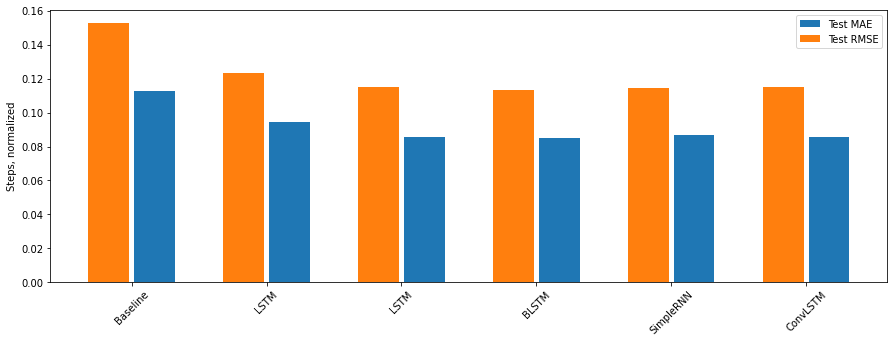

In [ ]:
x = np.arange(len(results[results.N_K == "7_1"]))
width = 0.3

metric_name = 'MAE'
#metric_index = lstm_model.metrics_names.index('mean_absolute_error')
#val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = results[results.N_K == "7_1"].MAE
test_rmse = results[results.N_K == "7_1"].RMSE

plt.figure(figsize=(15, 5))
plt.ylabel('Steps, normalized')
#plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test MAE')
plt.bar(x - 0.17, test_rmse, width, label='Test RMSE')
plt.xticks(ticks=x, labels=results[results.N_K == "7_1"].Model,
           rotation=45)
_ = plt.legend()

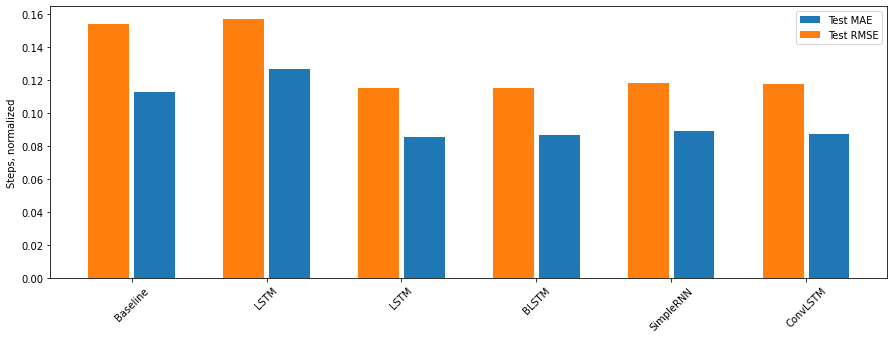

In [ ]:
x = np.arange(len(results[results.N_K == "14_1"]))
width = 0.3

metric_name = 'MAE'
#metric_index = lstm_model.metrics_names.index('mean_absolute_error')
#val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = results[results.N_K == "14_1"].MAE
test_rmse = results[results.N_K == "14_1"].RMSE

plt.figure(figsize=(15, 5))
plt.ylabel('Steps, normalized')
#plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test MAE')
plt.bar(x - 0.17, test_rmse, width, label='Test RMSE')
plt.xticks(ticks=x, labels=results[results.N_K == "14_1"].Model,
           rotation=45)
_ = plt.legend()

## Save the models and configurations

In [ ]:
with open('drive/MyDrive/Colab Notebooks/step-counts-prediction/models1.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)